# Automatic Number Plate Recognition with Apache MXNet (Gluon)

Authors: Brad Kenstler, Sunil Mallya

# Problem

Given an image of a car, locate the number plate and read the number plate sequence
<insert image>

## Introduction

The practice of using number plates (British for license plates) to uniquely identify automobiles is globally ubiquitous, and it is often the case that one may wish to record the number plates of automobiles in a given scenario. Such scenarios might include:
* Tracking entrance / exit time of a given vehicle into a parking facility
* Identifying an vehicle for traffic violation enforcement
* Identifying when an unauthorized vehicle has entered a restricted space

These are perfect examples of use cases where it would be optimal to automate the task of number plate recognition.
This tutorial looks at using the Gluon, the imperative interface for Apache MXNet(incubating) to train a Convolutional Neural Network for recognizing British number plates (license plates). Given an arbitrary image, the network will be able to:
* Detect the **location** of the number plate in the image
* Read the number plate **sequence**

The approach given here is adapted from that given by Matthew Earl in his blog post [Number plate recognition with Tensorflow](http://matthewearl.github.io/2016/05/06/cnn-anpr/#image_credits).

For introduction to Convolutional Neural Network refer to Zach Lipton's [tutorial](https://github.com/zackchase/mxnet-the-straight-dope)

# Dataset

Since there isn't an easily accessible dataset, we take Earl's approach in creating the license plate dataset. We source the backgrounds from the SUN [database](http://vision.cs.princeton.edu/projects/2010/SUN). By doing so we attempt to avoid the neural net to overfit on backgrounds and improve predictions on novel backgrounds.

The images can be pre-processed images can be downloaded from  https://s3.amazonaws.com/smallya-test/license-plate-images.tar.gz

<@Vinayak - Upload to DeepCam repo and use that link> 

### Prerequisites

This tutorial assumes that you possess understanding of deep learning fundamentals, such as:
* Components of a Neural Network (fully-connected layers, sigmoid/softmax, activation functions, etc.)
* Loss functions (MSE, Binary/categorical cross-entropy)
* Optimization approaches (SGD, Adam)

In addition, you should understand the basics of Convolutional Neural Networks.

### Overview

In this tutorial, we will:
* Learn how to generate synthetic training data for this task
* Demonstrate how to train a CNN that simultaneously detects the presence of a number plate and the sequence it displays
* Show how to create a Fully Convolutional NN from the training CNN that effectively applies the training CNN to "windows" across an input of arbirtrary size
* Explain how to use this network to produce a final output bounding box / sequence prediction

## Setup

@Vinayak/Guy -- Insert the IM infrastructure part here

In [1]:
# imports

from __future__ import division
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
from PIL import Image
import numpy as np
import os
from os.path import join as path_join
import matplotlib.pyplot as plt
import time
import collections
import itertools
import math
import urllib2
import cv2
from IPython import display
%matplotlib inline

The code we're going to use for generating training data, as well as postprocessing the detector output, is adapted from Matthew Earl's accompanying repository [Deep-ANPR](https://github.com/matthewearl/deep-anpr) and is provided in the helper utility file `deep_anpr.py`

In [2]:
import deep_anpr_utils; reload(deep_anpr_utils)
import deep_anpr_utils

Make sure to set this variable to the respective directory on your machine that contains the `fonts`, `bgs` and `test` dirs.

In [3]:
PATH = "/home/ubuntu/data/deep-anpr/"

if not os.path.exists(PATH):
    raise ValueError("Please set the right path for fonts and test directory") 

## Number Plate Generator

In order to train a network to detect and recognize British number plates, we need a dataset of images containing British number plates. Unfortunately, no such dataset is readily available. Fortunately, due to the extreme simplicity of British number plates it is very easy to synthesize a dataset for training online.

The steps taken by Earl to synthesize these images are as follows:
* Construct an artificial British number plate
* Transform the plate within a 64x128 window to randomize it's physical orientation and window position
* Composite the plate with a random background image
* Add noise

We're going to take a look at each step.

### Create a Number Plate

The first step in synthesizing a viable training image is to create the number plate itself. To do this, we start by loading character images from the font file `UKNumberPlate.ttf`.

In [4]:
FONT_PATH = path_join(PATH,"fonts")
UK_font_generator = deep_anpr_utils.make_char_ims(path_join(FONT_PATH,deep_anpr_utils.UK_FONT),
                                                  deep_anpr_utils.FONT_HEIGHT)
char_ims = {char:im for char, im in list(UK_font_generator)}

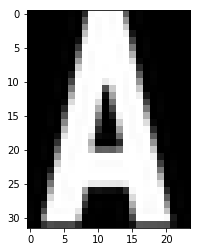

In [5]:
plt.imshow(char_ims["A"], cmap=plt.cm.gray)

Once we have these loaded, we can build a number plate.

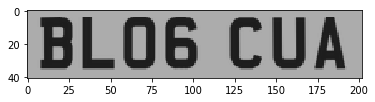

In [6]:
plate, plate_mask, code = deep_anpr_utils.generate_plate(deep_anpr_utils.FONT_HEIGHT, char_ims)
plt.imshow(plate, cmap=plt.cm.gray, vmin=0, vmax=1);

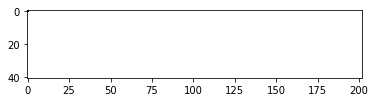

In [7]:
plt.imshow(plate_mask, cmap=plt.cm.gray, vmin=0, vmax=1)

In [8]:
code

'BL06CUA'

`generate_plate` method returns 3 things:
* The generated plate
* A plate mask for rounding corners
* The code sequence

It does many things to ensure sufficient variation within the plate itself:
* The sequence itself is randomly generated, in accordance with the `AB01 CDE` format for British plates
* The horizontal and vertical boundaries are randomly selected within reasonable values
* Likewise for spacings between characters and rounding of plate corners
* Randomly selects colors, ensuring the text is darker by a minimum difference in intensity

As we will see, this is entirely sufficient for synthesizing British plates. This may be surprising to many in countries where license plates vary significantly, or whose numbers are embossed. British plates are neither embossed, nor have any sort of background.

### Transform Plate & Composite with Background Image

Ideally, we would like our synthesized data to be of a British plate on an actual car. Unfortunately, that's not particularly feasible. 

Instead, we can take the synthesized plate, and overlay it on random background images. It's reasonable to expect that a network trained on such a synthesized dataset would work well with plates on cars, because it will have learned to ignore everything outside of the plate anyways.

Of course, we don't want to use flat synthesized plates always because that we want to account for the variety of angles / positions a plate is likely to be in. To this end, we transform the plate in physical dimension along all axes. We also account for scale and translational variance by randomly scaling and translating accordingly.

Recall the plate we just generated:

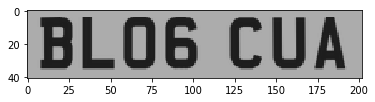

In [9]:
plt.imshow(plate, cmap=plt.cm.gray, vmin=0, vmax=1);

Let's look inside the `generate_im` method from `deep_anpr` to see step by step how this works.

In [10]:
#generate_im method needs to know how many background images we have so we'll go ahead and store that in this variable
num_bg_images = len(os.listdir(path_join(PATH, "bgs")))

In [11]:
"""
The MIT License (MIT)

Copyright (c) 2015 matthewearl

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

bg = deep_anpr_utils.generate_bg(PATH, num_bg_images)

M, out_of_bounds = deep_anpr_utils.make_affine_transform(
                        from_shape=plate.shape,
                        to_shape=bg.shape,
                        min_scale=0.6,
                        max_scale=0.875,
                        rotation_variation=1.0,
                        scale_variation=1.5,
                        translation_variation=1.2)
plate = cv2.warpAffine(plate, M, (bg.shape[1], bg.shape[0]))
plate_mask = cv2.warpAffine(plate_mask, M, (bg.shape[1], bg.shape[0]))

out = plate * plate_mask + bg * (1.0 - plate_mask)

out = cv2.resize(out, (deep_anpr_utils.OUTPUT_SHAPE[1], deep_anpr_utils.OUTPUT_SHAPE[0]))

out += np.random.normal(scale=0.05, size=out.shape)
out = np.clip(out, 0., 1.)

Let's look at what's happening. First we grab a background image:

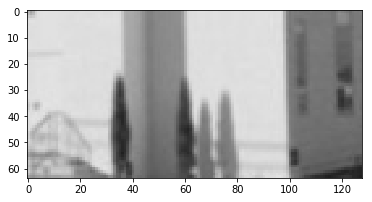

In [12]:
plt.imshow(bg, cmap=plt.cm.gray, vmin=0, vmax=1)

Next, `make_affine_transform` is called. This randomly generates the matrix `M` needed to warp the images as discussed. 

It also returns a boolean indicator `out_of_bounds`. This tells us whether the result of this transformation keeps the plate reasonably within the window for recognition, and is one of our targets for this network.

Recall that we will effectively be applying this network on "windows" across an arbitrary input. Part of what our network predicts is whether or not the window contains a viable plate to read from. As such, it's important to synthesize **negative samples** containing no or partial plates so the network will learn to discern between the two.

With `M`, we can warp our plate:

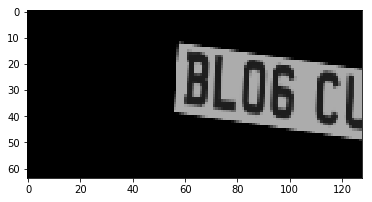

In [13]:
plt.imshow(plate, cmap=plt.cm.gray, vmin=0, vmax=1)

Then the method will output this warped image overlaid on the background, plus Gaussian noise for noise invariance. All composite images are resized to 64x128 as a standard dimension for input.

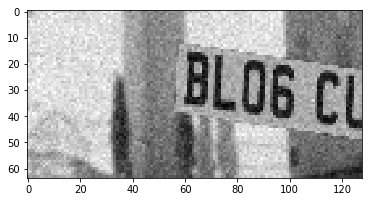

In [14]:
plt.imshow(out, cmap=plt.cm.gray, vmin=0, vmax=1)

### Training Batch Iterator

Now that we understand how our images are being synthesized, we can take a look at the batch iterator we'll be using to train our network on.

In [15]:
training_data = deep_anpr_utils.read_batches(PATH, batch_size=10, iterations=1000)
imgs, labels = next(training_data)

Our inputs come in the shape of `(Batch, Channel, Height, Width)`. Since these are gray-scale there is only 1 channel.

In [16]:
imgs.shape

(10L, 1L, 64L, 128L)

Let's look at an example:

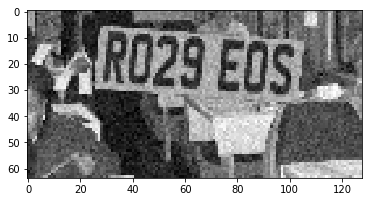

In [17]:
plt.imshow(imgs[0,0,:,:].asnumpy(), cmap = plt.cm.gray, vmin=0, vmax=1)

Let's take a closer look at our labels:

In [18]:
labels.shape

(10L, 253L)

The target for each image is a 253-element vector. The first element of the vector is the binary indicator value we mentioned. For this particular image:

In [19]:
print "Indicator: %s" % bool(labels[0][0].asscalar())

Indicator: True


The remaining 232 are concatenated one-hot encodings of the sequence. There are 36 possible symbols, and 7 symbols in each plate:

In [20]:
sequence = ''
one_hot_encodings = labels[0][1:].asnumpy().reshape((7, 36))
for one_hot_encoding in one_hot_encodings:
    sequence += deep_anpr_utils.CHARS[np.argmax(one_hot_encoding)]

In [21]:
print "Plate sequence: %s" % sequence

Plate sequence: RO29EOS


We're going to wrap this generator in an iterator class, so we can reset the generator inside our fitting function for our model.

In [7]:
class ResettableGenerator:
    def __init__(self, generator_func, args):
        self.args = args
        self.generator_func = generator_func
        self.generator = generator_func(*args)

    def __iter__(self):
        return self

    def next(self): 
        return next(self.generator)
            
    def reset(self):
        self.generator = self.generator_func(*self.args)

## Training CNN

Now that we understand the data we're synthesizing for training, as well as our targets, we can actually train a network.

We'll be using the newly released Gluon imperative interface for Apache MXNet for defining and training our models. The Gluon interface allows for dynamic networks combining symbolic representations with imperative definitions, and utilizes a developer friendly API. For a quick summary, take a look at the introduction [here](https://aws.amazon.com/blogs/aws/introducing-gluon-a-new-library-for-machine-learning-from-aws-and-microsoft/), and for extensive tutorials please check out [Deep Learning - The Straight Dope](http://thestraightdope.mxnet.io/).

The network we'll be training is a Convolutional Neural Network:
* Three convolutional layers w/ max-pooling
* Two fully connected layers
* **Input**: 1x64x128 gray-scale images
* **Output**: 253-element vectors of the form `[binary_indicator, char0_one_hot_encoding, ..., char6_one_hot_encoding]`, where `binary_indicator` is a binary flag indicating whether the image contains a valid plate, and `char{i}_one_hot_encoding` is a 36-element (# of possible characters) one-hot encoding for the i-th character in the plate sequence. Given that there are 7 elements in the sequence, the output is `1 + 7*36 = 253`. 

The input / output of course correspond to the input / label batches yielded from the training batch iterator discussed previously.

We'll use a BaseCNN instance to build our model. Please read comments where appropriate.

In [8]:
class BaseCNN(mx.gluon.Block):
    def __init__(self, ctx):
        super(BaseCNN, self).__init__()
        self.ctx = ctx
        self.net = None
        # Want to keep track of previous epoch for record-keeping
        self.prev_epoch = 0
        # Keep track of losses across training iterations
        self.moving_losses = []
        self.curr_losses = []
        
    #@override
    def build_model(self, convs, num_fc, num_output):
        '''
        Builds a CNN with variable conv layers, and final two dense layers.
        '''
        # convs = [(channel, kernel_sz, padding_siz, pool_siz, stride)quintuplets *N]
        cnn_layers = gluon.nn.HybridSequential(prefix='')
        for ch, k_sz, padding_sz, pool_sz, stride in convs:
            cnn_layers.add(gluon.nn.Conv2D(channels=ch, kernel_size=k_sz, padding=padding_sz, activation='relu'))
            cnn_layers.add(gluon.nn.MaxPool2D(pool_size=pool_sz, strides=stride)) # strides fixed for now
            
        net = gluon.nn.HybridSequential()
        with net.name_scope():
            net.add(cnn_layers)
            # Flatten and apply fully connected layers
            net.add(gluon.nn.Flatten())
            net.add(gluon.nn.Dense(num_fc, activation="relu"))
            net.add(gluon.nn.Dense(num_output))

        # speed up execution with hybridization
        net.hybridize()
        self.net = net
    
    def forward(self):
        pass

    def compile_model(self, loss=None, optimizer='sgd', lr=1E-3, init_mg=2.24):
        '''
        Compiles the model with Xavier initialization at given magnitude,
        loss function and optimizers as provided.
        '''
        print(self.net)
        self.net.collect_params().initialize(mx.init.Xavier(magnitude=init_mg), ctx=self.ctx)
        self.loss = gluon.loss.SoftmaxCrossEntropyLoss() if loss is None else loss
        self.optimizer = mx.gluon.Trainer(self.net.collect_params(), 
                                          optimizer, {'learning_rate': lr})
    
    def evaluate_metrics(self, datas, metrics, iterators):
        '''
        Given a list of data sources and metrics, calculate metrics on given sources.
        If a data source is an iterator, reset it after StopIteration.
        '''
        results = []
        for i, data in enumerate(datas):
            for d, l in data:
                d = d.as_in_context(ctx)
                l = l.as_in_context(ctx)
                o = self.net(d)
                for metric in metrics:
                    metric.update(o, l)
                        
            
            results.append([metric.get()[1] for metric in metrics])
            # reset metric counter between data source
            for metric in metrics:
                metric.reset()
            # reset data source if it is an iterator
            if iterators[i]:
                data.reset()
        return results
        
    def fit(self, train_data, test_data, epochs, metrics = [], evaluate_both=True,
            train_iterator = False, test_iterator = False, verbose=True):
        '''
        Fitting method allows for fitting on both lists and generators.
        If fitting on generators, be sure to use ResettableGenerator wrapper
        to allow for reset after epoch, and indicate on flags.
        Metrics can be provided for evaluation on datasets.
        Can choose to evaluate both training and test data, or just test data.
        If verbose, loss and provided metrics will be printed to stdout,
        else they will be appended to file `train_log.txt`
        '''
        smoothing_constant = .01
        ctx = self.ctx
        for e in range(epochs):
            for i, (data, label) in enumerate(train_data):
                data = data.as_in_context(ctx)
                label = label.as_in_context(ctx)
                with autograd.record(train_mode=True):
                    output = self.net(data)
                    loss = self.loss(output, label)
                loss.backward()
                self.optimizer.step(data.shape[0])

                ##########################
                #  Keep a moving average of the losses
                ##########################
                curr_loss = nd.mean(loss).asscalar()
                self.curr_losses.append(curr_loss)
                moving_loss = (curr_loss if ((i == 0) and (self.prev_epoch + e == 0)) 
                               else (1 - smoothing_constant) * self.moving_losses[-1] + (smoothing_constant) * curr_loss)
                self.moving_losses.append(moving_loss)
            # if using iterator, reset
            if train_iterator:
                train_data.reset()
            response = "Epoch %s. Loss: %s, " % (self.prev_epoch + e, moving_loss)
            if metrics:
                # evaluate on either both sets or only test
                if evaluate_both:
                    results = self.evaluate_metrics([train_data, test_data], metrics, [train_iterator, test_iterator])
                    evaluated_sets = ["Train", "Test"]
                else:
                    results = self.evaluate_metrics([test_data], metrics, [test_iterator])
                    evaluated_sets = ["Test"]
                # append metrics to response string
                for i, result in enumerate(results):
                    response += ",".join(["%s %s %s " % (evaluated_sets[i], metrics[k].name, m) for k, m in enumerate(result)])
            # print out string or append to file 
            if verbose:
                print response+"\n"
            else:
                with open("train_log.txt", mode="a") as log:
                    log.write(response+"\n")
        self.prev_epoch += e + 1

### Lets define our loss function for the task

The output of our model is one binary prediction, and 7 predictions of 36 classes. As such, our total loss function will be the sum of one binary cross entropy and 7 categorical cross entropies. Importantly, we also zero out the categorical loss values for observations whose indicator label is False; we don't want to penalize the model for bad sequence predictions on an observation with no viable plate.

In [9]:
def deep_anpr_loss(o, l):
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)
    sigmoid_cross_entropy = gluon.loss.SigmoidBinaryCrossEntropyLoss()
    indicator_loss = sigmoid_cross_entropy(o[:,0], l[:,0])
    digits_loss = softmax_cross_entropy(
        nd.reshape(o[:,1:],[-1, 36]), 
        nd.reshape(l[:,1:],[-1, 36])
    )
    d_loss = nd.multiply(
        nd.sum_axis(digits_loss.reshape([-1, 7]), 1),
        l[:,0] != 0
    )
    return indicator_loss + d_loss

### Custom Metrics

For our model, we're going to be using some custom metrics:
* **indicator_accuracy**: The accuracy of the first element in the output, which corresponds to the binary indicator value. An operating point of 0.99 is suggested by Earl, so it is set as default
* **within-sequence accuracy**: The total accuracy of character predictions across all viable sequences in a batch.
* **complete-sequence accuracy**: How accurate the model is at predicting an entire viable sequence correctly.
* Sequences are considered viable if the label indicator is True

British number plates have 7 symbols, and the total number of characters is 36 so we use these accordingly.

In [10]:
def indicator_accuracy(p, l, thr=0.99):
    p, l = p[0], l[0]
    p = 1 if p > thr else 0
    return np.mean((p==l))

def sequence_classes(p, l, seq_len=7, char_size=36):
    p, l = p[1:].reshape((seq_len, char_size)), l[1:].reshape((seq_len, char_size))
    p_classes, l_classes = np.argmax(p, axis=1), np.argmax(l, axis=1)
    return p_classes, l_classes

def within_sequence_accuracy(p, l, seq_len=7, char_size=36):
    #if label indicator is false, we don't want to include this metric for this obs.
    # return 0, and do not increment the obs counter
    if l[0] == 0:
        return (0, 0)
    p_classes, l_classes = sequence_classes(p, l, seq_len, char_size)
    return (np.mean(np.equal(p_classes, l_classes)), 1)

def complete_sequence_accuracy(p, l, seq_len=7, char_size=36):
    # same as above
    if l[0] == 0:
        return (0, 0)
    p_classes, l_classes = sequence_classes(p, l, seq_len, char_size)
    return (np.mean(np.sum(np.equal(p_classes, l_classes), axis=0) == 7), 1)

We're going to build custom MXNet metrics from these metric functions, in order to use to MXNet metric API during evaluation.

In [11]:
indicator_acc = mx.metric.CustomMetric(indicator_accuracy, name="indicator acc")
within_sequence_acc = mx.metric.CustomMetric(within_sequence_accuracy,
                                                  name='within-seq acc')
complete_sequence_acc = mx.metric.CustomMetric(complete_sequence_accuracy,
                                                  name='complete-seq acc')

Finally, we can define our training and test data. The training generator will output 1000 iterations per epoch, w/ batch size of 100. The test data is a hold out set of 1000 pre-generated images from our synthesization process.

In [12]:
TEST_IMGS = path_join(PATH, "test/*.png")
training_data = ResettableGenerator(generator_func=deep_anpr_utils.read_batches, args=(PATH, 100, 1000))
test_data = ResettableGenerator(generator_func = deep_anpr_utils.read_data, args=(TEST_IMGS, 1000))

Next we'll compile our model. Remember from the `build model` method that the conv parameters are `(Filters, Kernel size, padding, Pooling size, Pooling Stride)`. We use the same configuration as in Earl's approach.

Note that we're using the Adam optimizer instead of classic SGD. In short, Adam allows for adaptive per-parameter learning rates. Read more about it [here](http://ruder.io/optimizing-gradient-descent/index.html#adam).

In [13]:
ctx = mx.gpu()
deep_anpr = BaseCNN(ctx)
convs = [(48, 5, 2, 2, 2), (64, 5, 2, (2,1), (2,1)), (128, 5, 2, 2, 2)]
deep_anpr.build_model(convs=convs, num_fc=2048, num_output=1+7*len(deep_anpr_utils.CHARS))
deep_anpr.compile_model(loss=deep_anpr_loss, optimizer="Adam")

HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (2): Conv2D(64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2D(size=(2, 1), stride=(2, 1), padding=(0, 0), ceil_mode=False)
    (4): Conv2D(128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): Flatten
  (2): Dense(2048, Activation(relu))
  (3): Dense(253, linear)
)


In [14]:
deep_anpr.net.collect_params().load("deep_anpr_params", ctx)

Now we're going to train for 75 epochs. At 1000 iterations each w/ batch size of 100, this puts us at ~ 7.5 million unique synthesized observations we're training on.

We'll be evaluating using the metrics we defined above, but only on the hold-out test set. It wouldn't make sense to evaluate on the training set, since it is synthesized online.

This may take several hours, so we'll log the results. This is helpful if you need to close your notebook connection for any reason, since you can check `train_log.txt` from the command line as it trains to see how it's performing.

In [ ]:
deep_anpr.fit(
        training_data,
        test_data,
        epochs = 75,
        metrics = [indicator_acc, complete_sequence_acc, within_sequence_acc],
        evaluate_both = False,
        train_iterator=True,
        test_iterator=True,
        verbose=0)

Let's see how our model has been performing. The `BaseCNN` class keeps track of two values per iteration, the current loss per iteration and the moving average loss.

In determing the overall trend in model performance over time, the moving loss quantifies this better because it smooths out the variance in performance that we'd expect on a batch-to-batch basis.

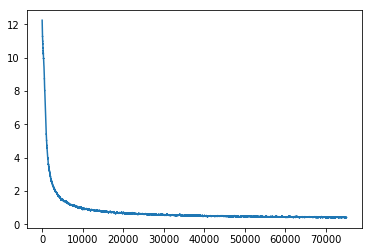

In [135]:
plt.plot(deep_anpr.moving_losses)

Indeed, we can see how much noisier the raw loss is.

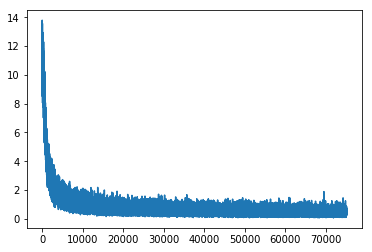

In [136]:
plt.plot(deep_anpr.curr_losses)

The shape of these graphs indicates that the learning rate selection of `0.001` by Earl was effective. The model is continuing to learn at a decaying rate, and we could keep training it longer if we so chose. For more on optimal learning rates check [this](http://cs231n.github.io/assets/nn3/learningrates.jpeg)

## Detection Net

### Problem
We have now successfully trained a CNN to make two types of predictions simultaneously, given an input image of `64x128`:
* Whether or not the input contains a viable number plate
* If so, what the number plate sequence is. If not, this is to be ignored.

This is great, but in a real application we won't be making predictions on a set of `64x128` images that may or may not contain a number plate. Rather, we will be given an image of arbitrary size that contains a license plate, and we want to know what's written on it.

We could **scan** the input, applying our trained network to `64x128` moving windows of a given stride across the image. This would give us predictions for each viable window, with which we could potentially:
* Find the window with the strongest indicator value
* Predict this window as the bounding box for the plate, and return the corresponding sequence prediction as our result

However, if we were to do this we would be recalculating much of the same convolutional features for overlapping windows. It would be significantly more efficient to pass the entire image through the convolutional layers only once, and perform the final two layer transformations on top of that.

### Solution
This brings us to the detection net. The detection net is an inference-only network that will:
* Take the task of iteratively applying the trained network across 64x128 windows for a given input image
* Reduce it to a single pass through a fully convolutional network (the detection net), the output of which are the outputs of the trained net on `64x128` windows of the input

How exactly do we accomplish this?

Consider the height and width of the output of the convolutional layers for the trained CNN:
* The input height and width is `64x128`
* First max-pooling reduces both by half to `32x64`
* Second max-pooling reduces only the height by half, to `16x32`
* Final max-pooling reduces both by half again to `8x32`
* Including the filters, the total dimension is `128x8x32`

The next step in our trained CNN is to flatten this output to a vector of `128x8x32 = 32768` elements, and multiply this by a weight matrix of dimension `2048x32768`.

However, let's say the input image has a larger dimension. Without knowing what that dimension is, we don't know what the dimension of the final convolutional output is either. However, **we do know** that if we take any `8x32` subsection of this final convolutional feature map we can trace it back to a `64x128` region of the input image.

Using this knowledge, we can take the `2048x32768` weight matrix from the trained CNN and reshape it to be a kernel of dimension `2048x128x8x32` for a fourth convolutional layer. Recall that convolutional layers apply their kernels across the previous layers output, therefore this new layer will have the effect of applying the first fully connected layer from the trained network to `64x128` regions on the input image. If we translate this kernel by one unit in each direction on the feature map, we can trace back through the previous conv layers to see that this corresponds to a `8x4` pixel translation of the `64x128` region. This means that the `(i-th, j-th)` coordinates in this 4th convolutional feature map correspond to the `64x128` region whose left corner is located at the `(8*i, 4*j)` pixel of the input (approximate when dimensions are odd or don't divide evenly).

Finally, we can reproduce our trained conv output on this new feature map through a similar method, this time reshaping the last fully connected weight matrix from our trained network to `253x2048x1x1` kernel. The `1x1` kernel perserves the shape of the previous feature map, and thus as with the previously layer, the `(i-th, j-th)` output at this final convolutional feature map corresponds to the output of the trained network applied to the `64x128` region whose left corner is located at the `(8*i, 4*j)` pixel of the input image (barring afore mentioned approximation).

We'll put together a special class for this network. It's only meant for inference, so there are no fitting methods available. Read comments when applicable for method explanation.

In [16]:
class DeepANPR_detector(mx.gluon.Block):

    def __init__(self, ctx):
        super(DeepANPR_detector, self).__init__()
        self.ctx = ctx
        self.net = None
        
    def build_model(self, convs):
        '''
        Default activation is relu
        '''
        # convs = [(channel, kernel_sz, padding_siz, pool_siz, stride)quintuplets *N]
        cnn_layers = gluon.nn.HybridSequential(prefix='')
        for ch, k_sz, padding_sz, pool_sz, stride in convs:
            cnn_layers.add(gluon.nn.Conv2D(channels=ch, kernel_size=k_sz, padding=padding_sz, activation='relu'))
            if pool_sz and stride:
                cnn_layers.add(gluon.nn.MaxPool2D(pool_size=pool_sz, strides=stride)) # strides fixed for now
            
        net = gluon.nn.HybridSequential()
        with net.name_scope():
            net.add(cnn_layers)

        # speed up execution with hybridization
        net.hybridize()
        self.net = net
        
    def compile_model(self):
        print(self.net)
        self.net.collect_params().initialize(mx.init.Zero(), ctx=self.ctx)
        
    def _infer_shape(self):
        '''
        Gluon defers parameter initialization until the first foward pass, where it is inferred
        from the input shape. We force that inference here before we can fill it with parameters from the 
        training net.
        '''
        _ = self.net(nd.zeros((5, 1, 300, 300), ctx=ctx))
        
    def load_params_from_net(self, source_net):
        '''
        Here we load the detection net with parameters from the training net,
        reshaping the last two dense layers into kernels for new conv layers.
        '''
        params = self.net.collect_params()
        keys = params.keys()
        if params[keys[0]].shape[1] == 0:
            self._infer_shape()
        source_net_params = source_net.collect_params()
        source_net_keys = source_net_params.keys()
        for i, name in enumerate(keys):
            if 'dense' not in source_net_keys[i] or 'bias' in source_net_keys[i]:
                params[name].set_data(source_net_params[source_net_keys[i]].data())  
        params[keys[6]].set_data(
            nd.reshape(source_net_params[source_net_keys[6]].data(),(2048,128,8,32))
        )
        params[keys[8]].set_data(
            nd.reshape(source_net_params[source_net_keys[8]].data(),(253,2048,1,1))
        )

Finally, we can build our detection network and load the parameters into this model.

In [17]:
detector = DeepANPR_detector(ctx)
convs = [(48, 5, 2, 2, 2), (64, 5, 2, (2, 1), (2, 1)), (128, 5, 2, 2, 2), (2048, (8, 32), 0, None, None),
        (1 + 7*len(deep_anpr_utils.CHARS), 1, 0, None, None)]
detector.build_model(convs)

detector.compile_model()

detector.load_params_from_net(deep_anpr)

HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (2): Conv2D(64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2D(size=(2, 1), stride=(2, 1), padding=(0, 0), ceil_mode=False)
    (4): Conv2D(128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (6): Conv2D(2048, kernel_size=(8, 32), stride=(1, 1))
    (7): Conv2D(253, kernel_size=(1, 1), stride=(1, 1))
  )
)


This really is a clever trick: for any task we can train a network on images at a reasonably small resolution for the ROI, and apply it across images of abritrary size by reshaping the fully connected weights into convolutional kernels. To be clear, this is **almost functionally the same** as applying the training network across 64x128 windows across the input image, at strides of 8 and 4 pixels (almost when dimensions are odd). However, using the detection net is much more efficient since it only requires a single foward pass.

Let's look at what the output is.

In [362]:
im = cv2.imread("proton_saga.jpg")
im = np.copy(im)
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) / 255.
im_gray = nd.array(np.expand_dims(np.expand_dims(im_gray, 0), 0))
im_gray.shape

(1L, 1L, 714L, 1024L)

In [34]:
out = detector.net(im_gray.as_in_context(ctx))

In [40]:
out.shape

(1L, 253L, 82L, 225L)

The first two dimension of the output are the same as the training net. The latter two tell you which 64x128 window this output corresponds to: it is the 64x128 window at left coords `(8*i, 4*j)`.

Of course, if you are unlucky and the ROI you wish to detect is poorly covered by these windows, you may run into trouble. Earl avoids this issue by applying the detection net to the input image at different scales, which effectively applies larger and larger windows across the input image.

We can visualize the effective behavior of his approach:

In [18]:
#GIF credit
#http://matthewearl.github.io/2016/05/06/cnn-anpr/
display.Image(url="http://matthewearl.github.io/assets/cnn-anpr/window-scan.gif")

After this, Earl classifies the indicator as present at an operating point of 0.99. For those that indicate a plate is present, Earl takes the intersection of their windows as the output bounding box, and the sequence prediction of the window with the highest indicator value as the output sequence.

I encourage you to look at his code to see how he does this!

For our purposes, we'll go ahead and visualize some predictions.

## Results

We can go ahead and download the images he used, to see if we get the same results! We'll use this helper function to download these images using `urllib2`.

In [19]:
def image_download(url, out_file):
    response = urllib2.urlopen(url)
    html = response.read()
    with open(out_file, mode="wb") as f:
        f.write(html)

In [23]:
proton_saga_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Proton_Saga_EV_at_the_RAC_Future_Car_Challenge_2011%2C_U.K.jpg/1024px-Proton_Saga_EV_at_the_RAC_Future_Car_Challenge_2011%2C_U.K.jpg"

In [24]:
image_download(proton_saga_url, "proton_saga.jpg")

In [25]:
deep_anpr_utils.predict_io("proton_saga.jpg", "out0.png", detector, ctx)

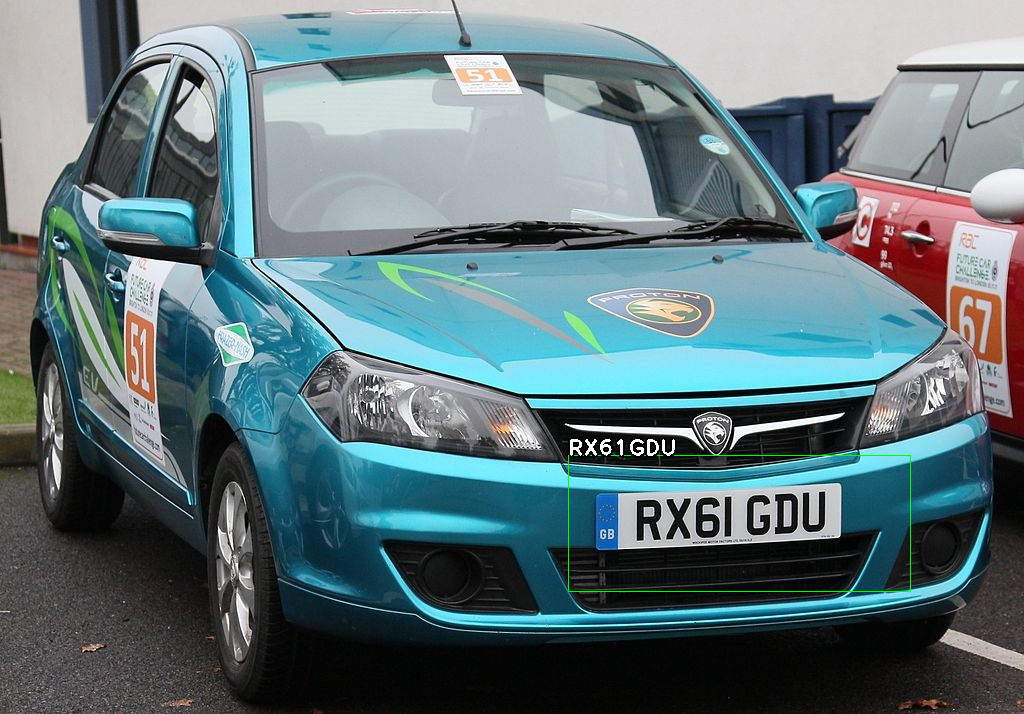

In [26]:
Image.open("out0.png")

In [27]:
gcar_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Google_Street_View_Car_near_Howden%2C_UK_2.JPG/576px-Google_Street_View_Car_near_Howden%2C_UK_2.JPG"

In [28]:
image_download(gcar_url, "gcar.jpg")

In [29]:
deep_anpr_utils.predict_io("gcar.jpg", "out1.png", detector, ctx)

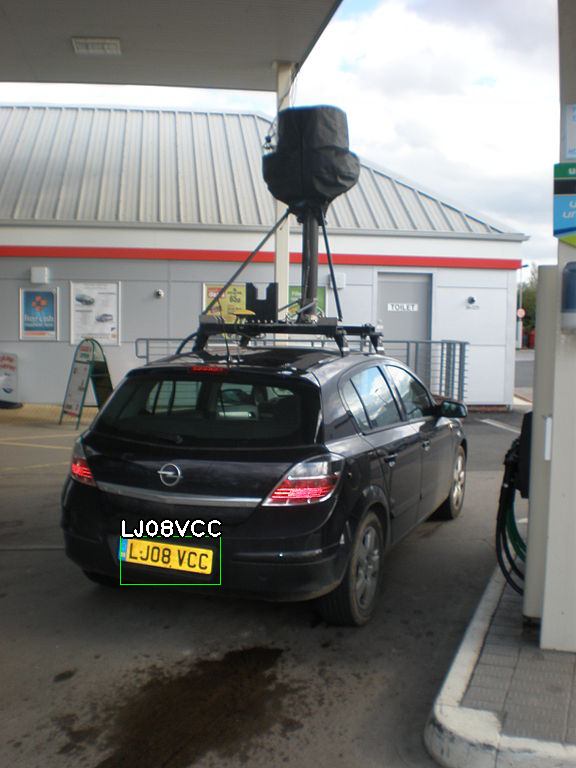

In [30]:
Image.open("out1.png")

They look great!

James Bond car for fun.

In [31]:
bond_url = "http://media.male-extravaganza.com/wp-content/uploads/2015/02/2002-Aston-Martin-Vanquish.jpg"

In [32]:
image_download(bond_url, "bond.jpg")

In [33]:
deep_anpr_utils.predict_io("bond.jpg", "out2.png", detector, ctx)

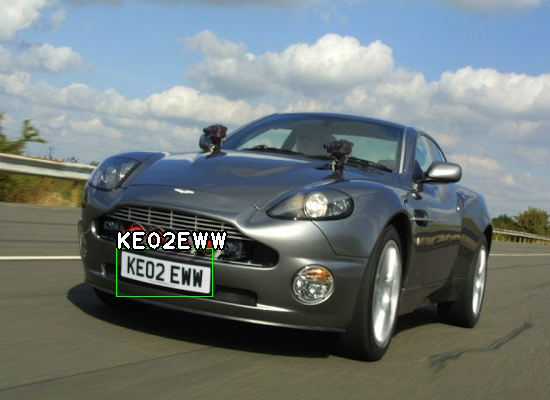

In [34]:
Image.open("out2.png")

In [45]:
test_data = list(deep_anpr_utils.read_data(TEST_IMGS, 1))

In [47]:
1 - np.sum([nd.sum(td[1][:,0]).asscalar() for td in test_data])/len(test_data)

0.55000000000000004